### Qcodes example notebook for Alazar card ATS9360 and acq controllers

In [1]:
%matplotlib notebook

In [2]:
import qcodes as qc
import qcodes.instrument.parameter as parameter
import qcodes.instrument_drivers.AlazarTech.ATS9360 as ATSdriver
from qdev_wrappers.alazar_controllers.ATS9360Controller import ATS9360Controller
from qcodes.station import Station

import logging

User schema at C:\Users\Jens/qcodesrc_schema.json not found.User settings won't be validated


NB: See ATS9360 example notebook for general commands 

In [3]:
# Create the ATS9360 instrument
alazar = ATSdriver.AlazarTech_ATS9360(name='Alazar')
# Print all information about this Alazar card
alazar.get_idn()

{'CPLD_version': '25.16',
 'SDK_version': '6.0.0',
 'asopc_type': '1779729248',
 'bits_per_sample': 12,
 'driver_version': '6.0.0',
 'firmware': None,
 'latest_cal_date': '25-01-17',
 'max_samples': 4294967294,
 'memory_size': '4294967294',
 'model': 'ATS9360',
 'pcie_link_speed': '0.5GB/s',
 'pcie_link_width': '8',
 'serial': '970396',
 'vendor': 'AlazarTech'}

In [4]:
alazar._handle

1468

In [5]:
# Configure all settings in the Alazar card
alazar.config(clock_source='INTERNAL_CLOCK',
              sample_rate=500000000,
              clock_edge='CLOCK_EDGE_RISING',
              decimation=1,
              coupling=['DC','DC'],
              channel_range=[.4,.4],
              impedance=[50,50],
              trigger_operation='TRIG_ENGINE_OP_J',
              trigger_engine1='TRIG_ENGINE_J',
              trigger_source1='EXTERNAL',
              trigger_slope1='TRIG_SLOPE_POSITIVE',
              trigger_level1=160,
              trigger_engine2='TRIG_ENGINE_K',
              trigger_source2='DISABLE',
              trigger_slope2='TRIG_SLOPE_POSITIVE',
              trigger_level2=128,
              external_trigger_coupling='DC',
              external_trigger_range='ETR_2V5',
              trigger_delay=0,
              timeout_ticks=0,
              aux_io_mode='AUX_IN_AUXILIARY', # AUX_IN_TRIGGER_ENABLE for seq mode on
              aux_io_param='NONE' # TRIG_SLOPE_POSITIVE for seq mode on
             )

## Example 1

Pulls the raw data the alazar acquires averaged over records and buffers.

In [6]:
# Create the acquisition controller which will take care of the data handling and tell it which 
# alazar instrument to talk to. Explicitly pass the default options to the Alazar.
# Dont integrate over samples but avarage over records
myctrl = ATS9360Controller(name='my_controller', alazar_name='Alazar',
                           integrate_samples=False, average_records=True)

c:\users\jens\src\qcodes\qcodes\instrument\parameter.py:207: UserWarning: Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.
  warnings.warn('Wrapping get method, original get method will not '
c:\users\jens\src\qcodes\qcodes\instrument\parameter.py:214: UserWarning: Wrapping set method, original set method will not be directly accessible. It is recommended to define set_raw in your subclass instead.
  warnings.warn('Wrapping set method, original set method will not '


Put the Alazar and the controller in a station so we ensure that all parameters are captured

In [7]:
station = qc.Station(alazar, myctrl)

This controller is designed to be highlevel and it is not possible to directly set number of records, buffers and samples. The number of samples is indirecly controlled by the integration time and integration delay and the number of averages controls the number of buffers and records acquired

In [8]:
myctrl.int_delay(2e-7)
myctrl.int_time(3.1e-6)
myctrl.num_avg(1000)

In [9]:
print("{} records per buffer set by num_avg".format(myctrl.records_per_buffer()))
print("{} samples per record set by int_time and int_delay".format(myctrl.samples_per_record()))

1000 records per buffer set by num_avg
2048 samples per record set by int_time and int_delay


Per default the output will contain an array called raw_output of unprocessed data

In [10]:
# Measure this 
data1 = qc.Measure(myctrl.acquisition).run()


DataSet:
   location = 'data/2017-11-21/#049_{name}_11-30-01'
   <Type>   | <array_id>               | <array.name> | <array.shape>
   Setpoint | time_set                 | time         | (2048,)
   Measured | my_controller_raw_output | raw_output   | (2048,)
acquired at 2017-11-21 11:30:01


<IPython.core.display.Javascript object>


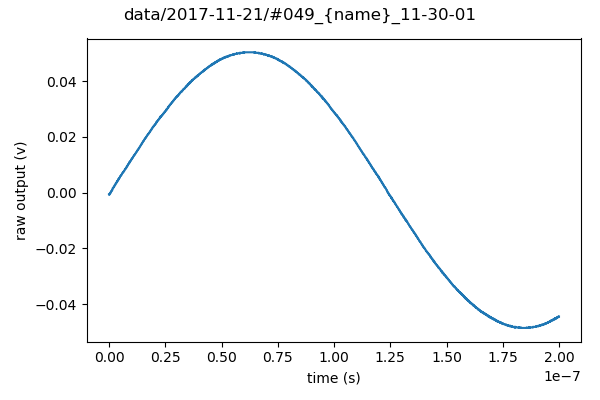

In [11]:
plot = qc.MatPlot(data1.my_controller_raw_output)


As we are not integrating over samples the setpoints (label, unit and ticks on number) are automatically set from the integration time and integration delay. **Note at the moment this does not cut of the int_delay from the plot. It probably should**

### Demodulation

We can add demodulators and remove them again, This will automatically take care of adapting the multiparameter to return multiple arrays to the dataset

In [12]:
myctrl.demod_freqs.add_demodulator(7e6)
myctrl.demod_freqs.add_demodulator(8e6)
myctrl.demod_freqs.add_demodulator(9e6)
myctrl.demod_freqs.add_demodulator(10e6)
myctrl.demod_freqs.add_demodulator(11e6)
myctrl.demod_freqs.add_demodulator(12e6)
myctrl.demod_freqs.add_demodulator(13e6)
print(myctrl.demod_freqs.get())

[7000000.0, 8000000.0, 9000000.0, 10000000.0, 11000000.0, 12000000.0, 13000000.0]


In this example we are demodulating a 10 MHz Signal from the Tektronix AWG

In [13]:
# Do this in as qcodes measurement (ie the same but makes a data set)
data2 = qc.Measure(myctrl.acquisition).run(station=station)


DataSet:
   location = 'data/2017-11-21/#050_{name}_11-30-04'
   <Type>   | <array_id>                       | <array.name>       | <array.shape>
   Setpoint | time_set                         | time               | (2048,)
   Measured | my_controller_raw_output         | raw_output         | (2048,)
   Measured | my_controller_demod_freq_0_mag   | demod_freq_0_mag   | (2048,)
   Measured | my_controller_demod_freq_0_phase | demod_freq_0_phase | (2048,)
   Measured | my_controller_demod_freq_1_mag   | demod_freq_1_mag   | (2048,)
   Measured | my_controller_demod_freq_1_phase | demod_freq_1_phase | (2048,)
   Measured | my_controller_demod_freq_2_mag   | demod_freq_2_mag   | (2048,)
   Measured | my_controller_demod_freq_2_phase | demod_freq_2_phase | (2048,)
   Measured | my_controller_demod_freq_3_mag   | demod_freq_3_mag   | (2048,)
   Measured | my_controller_demod_freq_3_phase | demod_freq_3_phase | (2048,)
   Measured | my_controller_demod_freq_4_mag   | demod_freq_4_mag   | (204

<IPython.core.display.Javascript object>


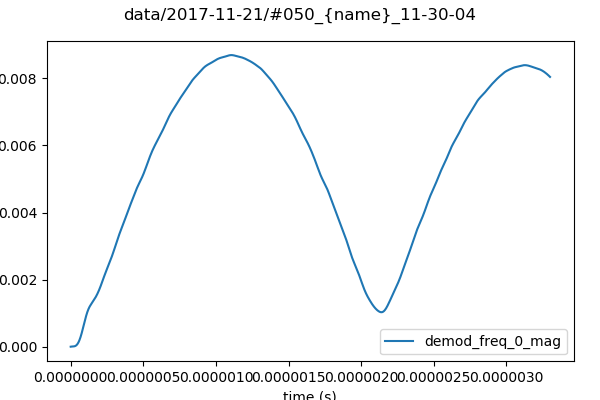

In [14]:
plot = qc.MatPlot()
plot.add(data2.my_controller_demod_freq_0_mag)
plot.fig.axes[0].legend()

<IPython.core.display.Javascript object>


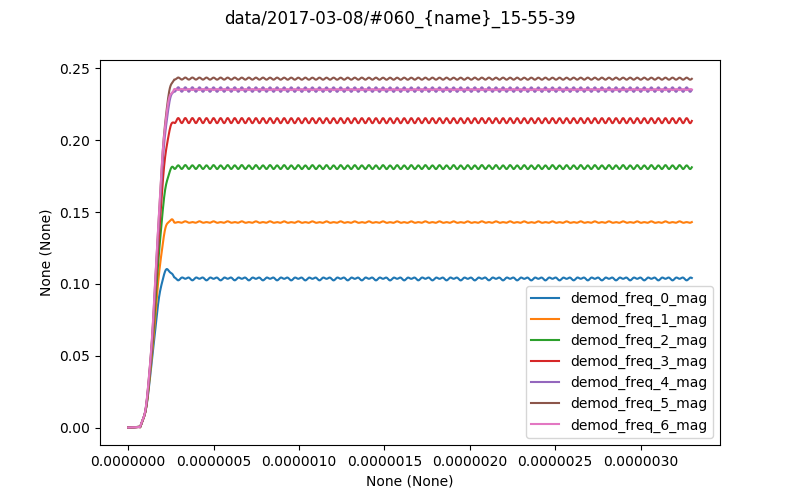

In [14]:
plot = qc.MatPlot(data2.my_controller_demod_freq_0_mag)
plot.add(data2.my_controller_demod_freq_1_mag)
plot.add(data2.my_controller_demod_freq_2_mag)
plot.add(data2.my_controller_demod_freq_3_mag)
plot.add(data2.my_controller_demod_freq_4_mag)
plot.add(data2.my_controller_demod_freq_5_mag)
plot.add(data2.my_controller_demod_freq_6_mag)
plot.fig.axes[0].legend()

There is currently a bug when plotting more than one lineplot the labels are missing

It's possible to change int_time, int_delay and num_avg in an already created acq_controller

In [15]:
myctrl.int_delay(2e-7)
myctrl.int_time(3e-6)
myctrl.num_avg(1)

DataSet:
   location = 'data/2017-11-21/#051_{name}_11-30-07'
   <Type>   | <array_id>                       | <array.name>       | <array.shape>
   Setpoint | time_set                         | time               | (2048,)
   Measured | my_controller_raw_output         | raw_output         | (2048,)
   Measured | my_controller_demod_freq_0_mag   | demod_freq_0_mag   | (2048,)
   Measured | my_controller_demod_freq_0_phase | demod_freq_0_phase | (2048,)
   Measured | my_controller_demod_freq_1_mag   | demod_freq_1_mag   | (2048,)
   Measured | my_controller_demod_freq_1_phase | demod_freq_1_phase | (2048,)
   Measured | my_controller_demod_freq_2_mag   | demod_freq_2_mag   | (2048,)
   Measured | my_controller_demod_freq_2_phase | demod_freq_2_phase | (2048,)
   Measured | my_controller_demod_freq_3_mag   | demod_freq_3_mag   | (2048,)
   Measured | my_controller_demod_freq_3_phase | demod_freq_3_phase | (2048,)
   Measured | my_controller_demod_freq_4_mag   | demod_freq_4_mag   | (204

<IPython.core.display.Javascript object>


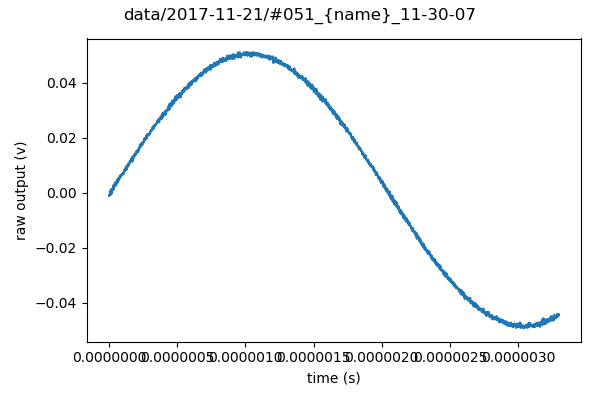

<IPython.core.display.Javascript object>


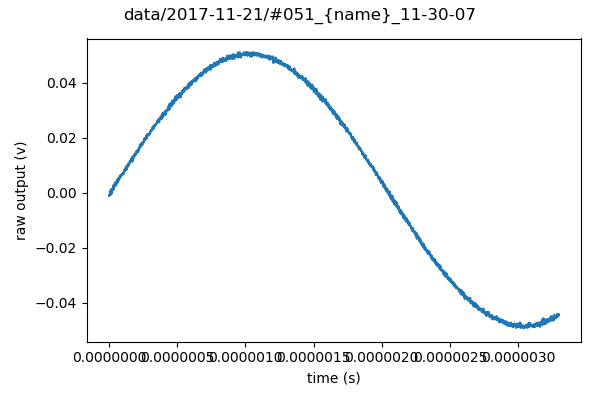

In [16]:
data3 = qc.Measure(myctrl.acquisition).run()
plot = qc.MatPlot(data3.my_controller_raw_output)
plot.fig

Assuming that you have establised the correct int time and delay we can integrate over samples. To change averaging and integrating setting you currently have to create a new controller

## Example 2

We can also chose to not average over records. You currently have to either integrate over samples or average over records (the returned data must be 1D)

In [17]:
# Create the acquisition controller which will take care of the data handling and tell it which 
# alazar instrument to talk to.
myintctrl = ATS9360Controller(name='my_controller_int', alazar_name='Alazar', integrate_samples=True)

c:\users\jens\src\qcodes\qcodes\instrument\parameter.py:207: UserWarning: Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.
  warnings.warn('Wrapping get method, original get method will not '
c:\users\jens\src\qcodes\qcodes\instrument\parameter.py:214: UserWarning: Wrapping set method, original set method will not be directly accessible. It is recommended to define set_raw in your subclass instead.
  warnings.warn('Wrapping set method, original set method will not '


In [18]:
myintctrl.int_delay(2e-7)
myintctrl.int_time(3e-6)
myintctrl.num_avg(100)

In [19]:
data4 = qc.Measure(myintctrl.acquisition).run()

DataSet:
   location = 'data/2017-11-21/#052_{name}_11-30-09'
   <Type>   | <array_id>                   | <array.name> | <array.shape>
   Setpoint | single_set                   | single       | (1,)
   Measured | my_controller_int_raw_output | raw_output   | (1,)
acquired at 2017-11-21 11:30:10


We can add the same demodulator freqs and look at the integrated samples 

In [20]:
myintctrl.demod_freqs.add_demodulator(7e6)
myintctrl.demod_freqs.add_demodulator(8e6)
myintctrl.demod_freqs.add_demodulator(9e6)
myintctrl.demod_freqs.add_demodulator(10e6)
myintctrl.demod_freqs.add_demodulator(11e6)
myintctrl.demod_freqs.add_demodulator(12e6)
myintctrl.demod_freqs.add_demodulator(13e6)
print(myintctrl.demod_freqs.get())


[7000000.0, 8000000.0, 9000000.0, 10000000.0, 11000000.0, 12000000.0, 13000000.0]


In [21]:
data5 = qc.Measure(myintctrl.acquisition).run()

DataSet:
   location = 'data/2017-11-21/#053_{name}_11-30-11'
   <Type>   | <array_id>                           | <array.name>       | <array.shape>
   Setpoint | single_set                           | single             | (1,)
   Measured | my_controller_int_raw_output         | raw_output         | (1,)
   Measured | my_controller_int_demod_freq_0_mag   | demod_freq_0_mag   | (1,)
   Measured | my_controller_int_demod_freq_0_phase | demod_freq_0_phase | (1,)
   Measured | my_controller_int_demod_freq_1_mag   | demod_freq_1_mag   | (1,)
   Measured | my_controller_int_demod_freq_1_phase | demod_freq_1_phase | (1,)
   Measured | my_controller_int_demod_freq_2_mag   | demod_freq_2_mag   | (1,)
   Measured | my_controller_int_demod_freq_2_phase | demod_freq_2_phase | (1,)
   Measured | my_controller_int_demod_freq_3_mag   | demod_freq_3_mag   | (1,)
   Measured | my_controller_int_demod_freq_3_phase | demod_freq_3_phase | (1,)
   Measured | my_controller_int_demod_freq_4_mag   | demod_f

We can also chose to not average over records. You currently have to either integrate over samples or average over records (the returned data must be 1D)

In [22]:
print(data5.my_controller_int_demod_freq_0_mag)
print(data5.my_controller_int_demod_freq_1_mag)
print(data5.my_controller_int_demod_freq_2_mag)
print(data5.my_controller_int_demod_freq_3_mag)
print(data5.my_controller_int_demod_freq_4_mag)
print(data5.my_controller_int_demod_freq_5_mag)
print(data5.my_controller_int_demod_freq_6_mag)

DataArray[1]: my_controller_int_demod_freq_0_mag
array([ 0.00530105])
DataArray[1]: my_controller_int_demod_freq_1_mag
array([ 0.00271576])
DataArray[1]: my_controller_int_demod_freq_2_mag
array([ 0.00108923])
DataArray[1]: my_controller_int_demod_freq_3_mag
array([ 0.00025257])
DataArray[1]: my_controller_int_demod_freq_4_mag
array([  8.81405815e-05])
DataArray[1]: my_controller_int_demod_freq_5_mag
array([  9.62218971e-05])
DataArray[1]: my_controller_int_demod_freq_6_mag
array([  4.00127536e-05])


As we can see the integrated samples seems consistent with the plots above.

## Example 3

In the last example we are running the AWG in sequencing mode. To do this we need to change the trigger to setup to enable a secondary trigger on the aux input. We change the alazar config here. 

In [23]:
alazar.config(clock_source='INTERNAL_CLOCK',
              sample_rate=500000000,
              clock_edge='CLOCK_EDGE_RISING',
              decimation=1,
              coupling=['DC','DC'],
              channel_range=[.4,.4],
              impedance=[50,50],
              trigger_operation='TRIG_ENGINE_OP_J',
              trigger_engine1='TRIG_ENGINE_J',
              trigger_source1='EXTERNAL',
              trigger_slope1='TRIG_SLOPE_POSITIVE',
              trigger_level1=160,
              trigger_engine2='TRIG_ENGINE_K',
              trigger_source2='DISABLE',
              trigger_slope2='TRIG_SLOPE_POSITIVE',
              trigger_level2=128,
              external_trigger_coupling='DC',
              external_trigger_range='ETR_2V5',
              trigger_delay=0,
              timeout_ticks=0,
              aux_io_mode='AUX_IN_TRIGGER_ENABLE', # AUX_IN_TRIGGER_ENABLE for seq mode on
              aux_io_param='TRIG_SLOPE_POSITIVE' # TRIG_SLOPE_POSITIVE for seq mode on
             )

In [24]:
myrecctrl = ATS9360Controller(name='my_controller_rec', alazar_name='Alazar', 
                              integrate_samples=True, average_records=False)

KeyError: 'Another instrument has the name: my_controller_rec'

When not averaging over records averaging is implemented by averaging over buffers and records_per_buffer can be set independently 

In [28]:
myrecctrl.int_delay(2e-7)
myrecctrl.int_time(3e-6)
myrecctrl.num_avg(100)
myrecctrl.records_per_buffer(8)
data6 = qc.Measure(myrecctrl.acquisition).run()


DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-08/#065_{name}_16-19-12'
   <Type>   | <array_id>                   | <array.name> | <array.shape>
   Setpoint | record_num_set               | record_num   | (8,)
   Measured | my_controller_rec_raw_output | raw_output   | (8,)
acquired at 2017-03-08 16:19:13


Here we are changing the driving freq of the AWG between the freqs below. We demodulate with the same frequencies in 8 records

In [49]:
demod_freqs = [5e6, 7e6, 9e6, 11e6, 13e6, 15e6, 17e6, 19e6]

In [32]:
for freq in demod_freqs:
    myrecctrl.demod_freqs.add_demodulator(freq)

As the setpoints along a records axis is expected to be dependent on an external instrument
which the driver has no way of knowing there is support for setting the base name, unit and start and stop of setpoints (the number of setpoints is automatically set from the number of records) as shown below

In [40]:
myrecctrl.acquisition.set_base_setpoints(base_name='awg_freq', base_label='awg freq', base_unit='Hz',
                             setpoints_start=5e6, setpoints_stop = 19e6)
data6 = qc.Measure(myrecctrl.acquisition).run()

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-08/#069_{name}_16-29-43'
   <Type>   | <array_id>                           | <array.name>       | <array.shape>
   Setpoint | awg_freq_set                         | awg_freq           | (8,)
   Measured | my_controller_rec_raw_output         | raw_output         | (8,)
   Measured | my_controller_rec_demod_freq_0_mag   | demod_freq_0_mag   | (8,)
   Measured | my_controller_rec_demod_freq_0_phase | demod_freq_0_phase | (8,)
   Measured | my_controller_rec_demod_freq_1_mag   | demod_freq_1_mag   | (8,)
   Measured | my_controller_rec_demod_freq_1_phase | demod_freq_1_phase | (8,)
   Measured | my_controller_rec_demod_freq_2_mag   | demod_freq_2_mag   | (8,)
   Measured | my_controller_rec_demod_freq_2_phase | demod_freq_2_phase | (8,)
   Measured | my_controller_rec_demod_freq_3_mag   | demod_freq_3_mag   | (8,)
   Measured | my_controller_rec_demod_freq_3_phase | demod_freq_3_phase | (8,)
   Measured | my_controller_rec

<IPython.core.display.Javascript object>


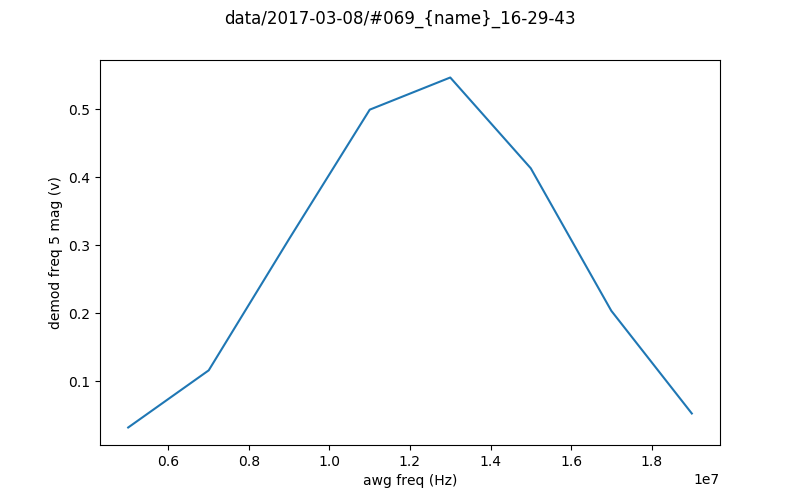

In [51]:
plot = qc.MatPlot(data6.my_controller_rec_demod_freq_5_mag)

<IPython.core.display.Javascript object>


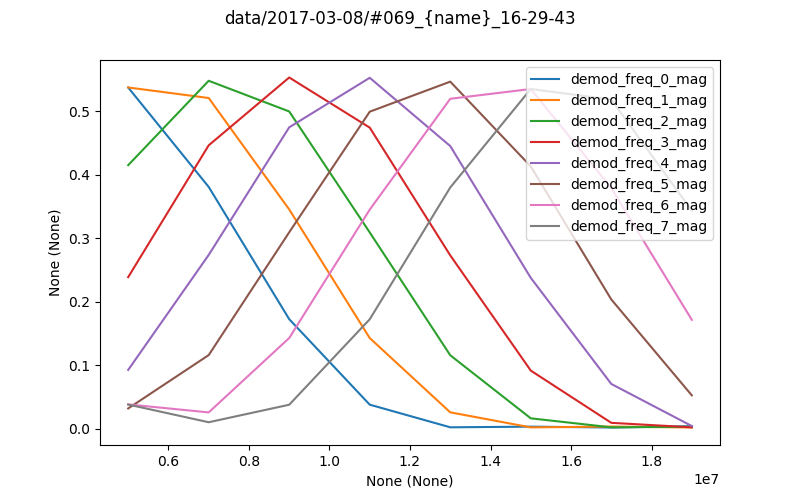

In [50]:
plot = qc.MatPlot(data6.my_controller_rec_demod_freq_0_mag)
plot.add(data6.my_controller_rec_demod_freq_1_mag)
plot.add(data6.my_controller_rec_demod_freq_2_mag)
plot.add(data6.my_controller_rec_demod_freq_3_mag)
plot.add(data6.my_controller_rec_demod_freq_4_mag)
plot.add(data6.my_controller_rec_demod_freq_5_mag)
plot.add(data6.my_controller_rec_demod_freq_6_mag)
plot.add(data6.my_controller_rec_demod_freq_7_mag)
plot.fig.axes[0].legend()